<a href="https://colab.research.google.com/github/Rohan-Chaudhury/Kaggle-Salt-Identification-/blob/master/salt_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install imageio


In [3]:
!pip install torch


    100% |████████████████████████████████| 591.8MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x60eb4000 @  0x7fd6b4f292a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [4]:
!pip install kaggle
!pip install pywidgets

  Could not find a version that satisfies the requirement pywidgets (from versions: )
No matching distribution found for pywidgets


In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imageio
import torch
from torch.utils import data

In [6]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rohanchaudhury","key":"6cd405f6015e171800af51f04d6ac36e"}'}

In [7]:
ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Jan 15 16:41 kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c tgs-salt-identification-challenge


  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 42.7MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 36.7MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 28.9MB/s]
 94% 154M/163M [00:08<00:00, 24.6MB/s]
100% 163M/163M [00:08<00:00, 20.7MB/s]
 87% 33.0M/37.9M [00:01<00:00, 22.9MB/s]
100% 37.9M/37.9M [00:01<00:00, 31.4MB/s]


In [10]:
!ls



depths.csv   sample_data	    test.zip   train.zip
kaggle.json  sample_submission.csv  train.csv


In [11]:
!rm -r images
!rm -r masks
!rm -r train
!rm -r test
!ls

rm: cannot remove 'images': No such file or directory
rm: cannot remove 'masks': No such file or directory
rm: cannot remove 'train': No such file or directory
rm: cannot remove 'test': No such file or directory
depths.csv   sample_data	    test.zip   train.zip
kaggle.json  sample_submission.csv  train.csv


In [12]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [13]:
!mkdir train
!mkdir test
!unzip train.zip
!cp -r images train
!cp -r masks train


Archive:  train.zip
   creating: images/
   creating: masks/
  inflating: images/8d08955cdf.png   
  inflating: images/e045664b46.png   
  inflating: images/4989c6509e.png   
  inflating: images/fff4eb4941.png   
  inflating: images/3a310860a3.png   
  inflating: images/7a696bb878.png   
  inflating: images/8d3ee9356b.png   
  inflating: images/213e0a9f7b.png   
  inflating: images/78f17697f2.png   
  inflating: images/bd20d18369.png   
  inflating: images/de08c5a3b7.png   
  inflating: images/f06ef6c8b7.png   
  inflating: images/b2d02516e1.png   
  inflating: images/5edb37f5a8.png   
  inflating: images/b1f0e104f5.png   
  inflating: images/40e8e14e60.png   
  inflating: images/6e1444d88d.png   
  inflating: images/f342603c76.png   
  inflating: images/7ba58ee1be.png   
  inflating: images/14a89a1840.png   
  inflating: images/4319885cf1.png   
  inflating: images/bb697642ae.png   
  inflating: images/d4acb30303.png   
  inflating: images/057eae4f34.png   
  inflating: images/9f0c9f3

In [14]:
!ls train

images	masks


In [15]:
!ls train/images



000e218f21.png	35499d9dd6.png	6957579961.png	99f52af0ea.png	cc876896b5.png
003c477d7c.png	356fa48ac4.png	697af33de9.png	9a1fbef3e3.png	cc97e87765.png
00441f1cf2.png	3577258d6b.png	697f80cece.png	9a3abd0ba6.png	ccc41663c6.png
0050766ae2.png	358b9acfb5.png	697fee88c5.png	9a478d8cf2.png	ccd6841e90.png
005b452274.png	359128303c.png	6994342067.png	9a48617407.png	ccdd1c542f.png
0061281eea.png	3598c246d7.png	699608ddb7.png	9a4864ff06.png	cced2adf43.png
008a50a2ec.png	35b34a9da1.png	69bb149e2d.png	9a4b15919d.png	ccfb270edb.png
00950d1627.png	35ba6f2faf.png	69cddf572c.png	9a4db0d7aa.png	cd1b2e49f4.png
00a3af90ab.png	35bbf1302b.png	69ee613976.png	9a4f625408.png	cd2046479c.png
00cda0328c.png	35f3cb48d6.png	6a0f5a8b42.png	9a672bfb51.png	cd249859fa.png
0108518d1e.png	35fd991255.png	6a105e7555.png	9a6c280d8d.png	cd292b7c8d.png
010ee525b6.png	361d5e6834.png	6a1783be17.png	9a6cf411ff.png	cd5c9532e4.png
0115703825.png	362cec7849.png	6a1fd3c67e.png	9a71e8563b.png	cd5cd074f1.png
01323211a0.png	3634f29aac

In [16]:
!ls
!rm -r images
!rm -r masks
!ls


depths.csv  kaggle.json  sample_data		test	  train      train.zip
images	    masks	 sample_submission.csv	test.zip  train.csv
depths.csv   sample_data	    test      train	 train.zip
kaggle.json  sample_submission.csv  test.zip  train.csv


In [17]:
!unzip test.zip
!cp -r images test



Archive:  test.zip
   creating: images/
  inflating: images/8cf16aa0f5.png   
  inflating: images/23012be6b7.png   
  inflating: images/9e46a3352e.png   
  inflating: images/8016056c46.png   
  inflating: images/a490a68472.png   
  inflating: images/cf19041b8e.png   
  inflating: images/a5c02f60cd.png   
  inflating: images/631cec82b9.png   
  inflating: images/bffa15aaa5.png   
  inflating: images/31e17c9459.png   
  inflating: images/b695427db8.png   
  inflating: images/57b062d234.png   
  inflating: images/1705ade299.png   
  inflating: images/f1a3d6352e.png   
  inflating: images/99e331e803.png   
  inflating: images/d343f6974e.png   
  inflating: images/068f7a5267.png   
  inflating: images/d4c235a41e.png   
  inflating: images/bf56f7dd40.png   
  inflating: images/6b8b1e7ad6.png   
  inflating: images/c268afb4a1.png   
  inflating: images/63ed0faeb8.png   
  inflating: images/4578fe28d8.png   
  inflating: images/8755799352.png   
  inflating: images/50e3fe9bc1.png   
  inflatin

In [18]:
!ls 

depths.csv  kaggle.json  sample_submission.csv	test.zip  train.csv
images	    sample_data  test			train	  train.zip


In [19]:
!ls test

images


In [20]:
!rm -r images
!ls

depths.csv   sample_data	    test      train	 train.zip
kaggle.json  sample_submission.csv  test.zip  train.csv


In [0]:
im_width = 128
im_height = 128
im_chan = 1
path_train = 'train/'
path_test = 'test/'

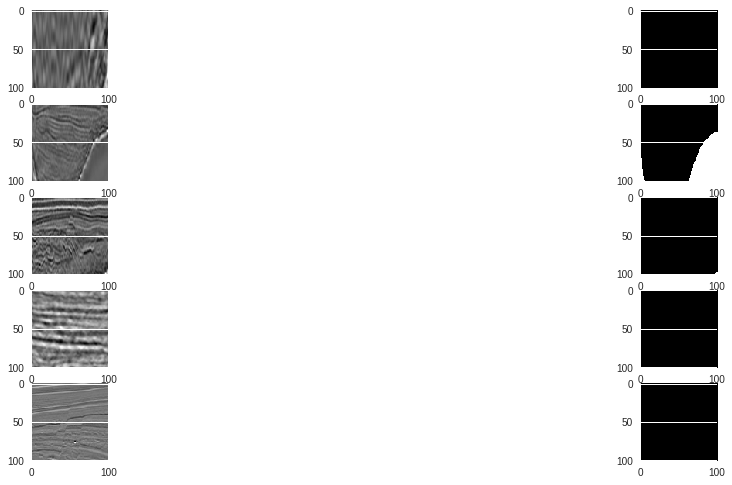

In [22]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('train/images/' + img_name + '.png')
    img_mask = load_img('train/masks/' + img_name + '.png')
    
    plt.subplot(1+len(ids),2,q*2-1)
    plt.imshow(img)
    plt.subplot(1+len(ids),2,q*2)
    plt.imshow(img_mask)
plt.show()

In [0]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]


In [24]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in enumerate(train_ids):
    path = path_train
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 
Done!


In [25]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [26]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)
sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

sess.close()


Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
10.541896455000142
GPU (s):
2.681557467999937
GPU speedup over CPU: 3x


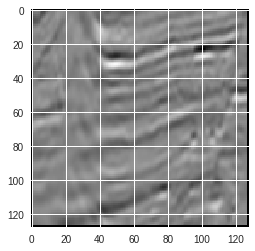

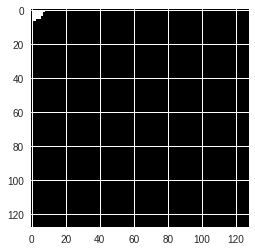

In [27]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [0]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [29]:
# Build U-Net model
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [30]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 24s 7ms/step - loss: 0.4760 - mean_iou: 0.3823 - val_loss: 0.3489 - val_mean_iou: 0.4144

Epoch 00001: val_loss improved from inf to 0.34895, saving model to model-tgs-salt-1.h5
Epoch 2/30
3600/3600 [==============================] - 22s 6ms/step - loss: 0.3954 - mean_iou: 0.4432 - val_loss: 0.4387 - val_mean_iou: 0.4631

Epoch 00002: val_loss did not improve from 0.34895
Epoch 3/30
3600/3600 [==============================] - 22s 6ms/step - loss: 0.3321 - mean_iou: 0.4863 - val_loss: 0.2919 - val_mean_iou: 0.5124

Epoch 00003: val_loss improved from 0.34895 to 0.29191, saving model to model-tgs-salt-1.h5
Epoch 4/30
3600/3600 [==============================] - 22s 6ms/step - loss: 0.3032 - mean_iou: 0.5332 - val_loss: 0.2684 - val_mean_iou: 0.5469

Epoch 00004: val_loss improved from 0.29191 to 0.26837, saving model to model-tgs-salt-1.h5
Epoch 5/30
3600/3600 [========================

In [31]:
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 



Done!


In [32]:
# Predict on train, val and test
model = load_model('model-tgs-salt-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

18000/18000 [==============================] - 17s 919us/step


In [33]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [34]:
preds_test_upsampled[0].shape

(101, 101)

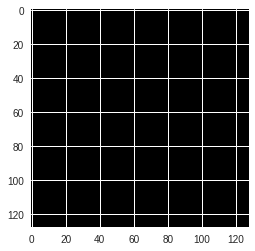

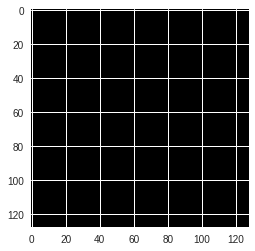

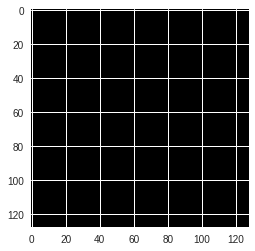

In [35]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [36]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}

In [0]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [0]:
files.download('submission.csv')

In [40]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f submission.csv -m "Messagexzvxvdxdv"

100% 6.00M/6.00M [00:11<00:00, 530kB/s]
Successfully submitted to TGS Salt Identification Challenge